### SenseFly: Quarry. *(127 images)*

([Mormont; Eclépens, Switzerland](https://www.openstreetmap.org/#map=14/46.6520/6.5340))

**Exploratory analysis and result**

In [1]:
import os
import glob

import math
import numpy as np
from laspy.file import File
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import AxesGrid

import seaborn as sns

from osgeo import gdal

**pose and dense reconstruction** *(openMVG -> openMVS)*

<img src="./img/pose_and_Dcloud.png" width="600" height="400" align="center"/>

**after PDAL**

In [57]:
#Read LAS file
inFile = File("./result_utm/las/sceneGeo_dense.las", mode = "r")

In [58]:
print('Examining Point Format: ')
pointformat = inFile.point_format
for spec in inFile.point_format:
    print(spec.name)

Examining Point Format: 
X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time
red
green
blue


In [59]:
#import LAS into numpy array 
rgb_points = np.array((inFile.x, inFile.y, inFile.z, inFile.raw_classification,
                         inFile.red, inFile.green, inFile.blue
                        )).transpose() # inFile.return_number,
inFile.close()
#colors = np.vstack((inFile.red, inFile.green, inFile.blue)).transpose()
print(len(rgb_points))

4583


In [60]:
#Transform to pandas DataFrame
rgb_df = pd.DataFrame(rgb_points, columns=['x', 'y', 'z', 'class', 'r', 'g', 'b'])
rgb_df.describe()

,x,y,z,class,r,g,b
count,4583.000000,4.583000e+03,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000
mean,311709.342562,5.169695e+06,564.555835,1.823696,103.253764,107.464325,91.298713
std,266.520501,1.639607e+02,45.698467,0.381120,57.844408,51.466236,49.496223
min,311155.820000,5.169301e+06,492.110000,1.000000,10.000000,11.000000,11.000000
25%,311494.135000,5.169576e+06,522.095000,2.000000,51.000000,64.000000,48.000000
50%,311727.490000,5.169707e+06,562.320000,2.000000,93.000000,103.000000,77.000000
75%,311927.215000,5.169831e+06,609.780000,2.000000,159.000000,153.000000,136.000000
max,312210.940000,5.170019e+06,661.400000,2.000000,247.000000,246.000000,235.000000


In [61]:
rgb_df.head(3)

,x,y,z,class,r,g,b
0,311873.29,5169815.96,564.85,2.0,141.0,137.0,117.0
1,311873.07,5169806.48,561.42,2.0,66.0,70.0,54.0
2,311873.50,5169797.32,556.99,2.0,132.0,128.0,116.0


In [62]:
print('diff x:', rgb_df.x.min() - rgb_df.x.max())
print('diff y:', rgb_df.y.min() - rgb_df.y.max())
print('diff z:', rgb_df.z.min() - rgb_df.z.max())

diff x: -1055.1199999999953
diff y: -718.0800000000745
diff z: -169.28999999999996


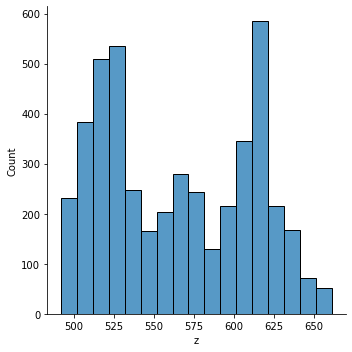

In [77]:
sns.displot(rgb_df.z)
plt.show()

In [73]:
factor=1
decimated_points_random = rgb_df[::factor]
print(len(decimated_points_random))

4583


In [74]:
decimated_points_random['class'].unique()

array([2., 1.])

In [75]:
extent = x_min, x_max, y_min, y_max = [rgb_df.x.min()-25, 
                                       rgb_df.x.max()+25,
                                       rgb_df.y.min()-25, 
                                       rgb_df.y.max()+25]
extent

[311130.82, 312235.94, 5169275.7, 5170043.78]

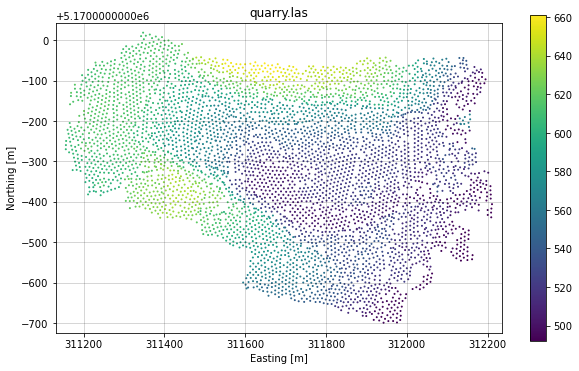

In [76]:
fig, ax = plt.subplots(figsize=(10,6))

cm = ax.scatter(decimated_points_random.x, decimated_points_random.y, 
                #c=decimated_points_random['class'], 
                c=decimated_points_random.z,
                s=1)

ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('quarry.las')
ax.grid(c='k', alpha=0.2)
fig.colorbar(cm)

plt.show()

**dtm**

In [79]:
files = glob.glob(os.path.join('./result_utm/*.tif'))
img_l = []
char2 = '.asc'
for file in files:
    ds = gdal.Open(file)#.ReadAsArray()
    array = ds.ReadAsArray()
    array  = np.flip(array, 0)
    nan_array = array
    nan_array[array == -9999] = np.nan
    img_l.append(nan_array)
    # close dataset
    ds = None
print(files)

['./result_utm\\sceneGeo_dense_dtm_tinLaplace.tif']


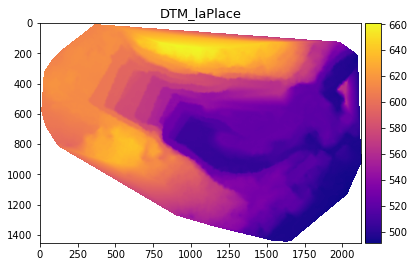

In [85]:
fig, ax = plt.subplots(figsize=(16, 16), sharey=True)

ax = plt.subplot(131)
cb = plt.imshow(img_l[0], cmap=plt.cm.plasma)
ax.set_title('DTM_laPlace', fontdict={'fontsize': 13, 'fontweight': 'medium'})
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)
#plt.colorbar()
fig.tight_layout()
plt.show()

**laPlace_TIN**

<img src="./img/laplaceTIN.png" width="600" height="400" align="center"/>